# Contents
- [Setup](#Setup)
- [Randomization Methods](#Randomization-Methods)
    - [Simple Randomization](#Simple-Randomization)  
    - [Stratified Sampling](#Stratified-Sampling)  
    - [Block Randomization](#Block-Randomization)  
    - [Match Pair Randomization](#Match-Pair-Randomization)  
    - [Cluster Randomization](#Cluster-Randomization)  
    - [CUPED](#CUPED)
- [AA Testing](#AA-Testing)
- [Power Analysis](#Power-Analysis)
- [AB Testing](#AB-Testing)
- [How Long](#How-Long)
- [Results](#Results)
    - [Visualization](#Visualization)
- [Post Hoc Analysis](#Post-Hoc-Analysis)
- [Other Notes](#Other-Notes)
    - [Experimentation-Infrastructure](#Experimentation-Infrastructure)
- [Scratch Notes](#Scratch-Notes)

# Setup

In [3]:
# Display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Data Seed

In [4]:
import pandas as pd
import numpy as np

# Set random seed
np.random.seed(42)

[Back to the top](#Contents)
___


# Randomization Methods

- Ensures that differences in outcome metrics are due to the experiment and not pre-existing differences between users.
- Eliminates selection bias (e.g., users choosing their own group).
- Helps balance confounding variables (e.g., demographics, device type, purchase history).
- Enables valid statistical inference.

### Simple Randomization
- Each user has an equal chance (e.g., 50/50 split for A/B) of being assigned to treatment or control.
- Works well when sample sizes are large.

In [ ]:
import numpy as np
import pandas as pd

# Sample user data
np.random.seed(42)  # For reproducibility
users = pd.DataFrame({'user_id': range(1, 101)})  # 100 users

# Assign each user to 'control' or 'treatment' with 50% probability
users['group'] = np.random.choice(['control', 'treatment'], size=len(users), p=[0.5, 0.5])

# Display the result
users

### Stratified Sampling
- Ensures balance across key segments (e.g., country, platform, user tenure).
- Example: If 60% of your users are on iOS and 40% on Android, simple randomization might cause an imbalance, so you stratify by platform.

In [ ]:
from sklearn.model_selection import train_test_split

# Create a sample dataset with 100 users and platform labels
np.random.seed(42)
users = pd.DataFrame({
    'user_id': range(1, 101),
    'platform': np.random.choice(['iOS', 'Android'], size=100, p=[0.6, 0.4])  # 60% iOS, 40% Android
})

# Stratify by platform to ensure balance
train, test = train_test_split(users, test_size=0.5, stratify=users['platform'], random_state=42)

# Assign groups
train['group'] = 'control'
test['group'] = 'treatment'

# Merge and display
users = pd.concat([train, test]).sort_values('user_id')
users

### Block Randomization

<!-- ### Blocked Randomization
- Ensures equal group sizes in small experiments.
- Example: If testing on 100 users, you create blocks of 10 and assign 5 to control and 5 to treatment within each block. -->


In [ ]:
# Define block size (e.g., groups of 10 users)
block_size = 10
users = pd.DataFrame({'user_id': range(1, 101)})

# Assign blocks
users['block'] = (users['user_id'] - 1) // block_size

# Within each block, randomly assign 50% to control and 50% to treatment
users['group'] = users.groupby('block')['user_id'].transform(lambda x: np.random.choice(['control', 'treatment'], size=len(x), replace=True))

# Drop the block column after assignment
users = users.drop(columns=['block'])
users

### Match Pair Randomization

Participants are paired based on similar characteristics before being randomly assigned to different groups. This ensures that treatment and control groups are balanced on key covariates, reducing variance and improving statistical power.

When to Use Matched-Pair Randomization?
- When you have a small sample size and need to control for confounders.
- When key characteristics (e.g., age, income, purchase history) could influence the outcome.
- When you want to minimize variance by ensuring similar individuals are in each group.

How It Works:
- Identify key variables that might impact the outcome (e.g., age, income, engagement level).
- Sort users based on these variables.
= Create pairs (or small groups) of users with similar characteristics.
- Within each pair, randomly assign one user to treatment and the other to control.


In [ ]:
import numpy as np
import pandas as pd

# Generate sample user data
np.random.seed(42)
users = pd.DataFrame({
    'user_id': range(1, 101),
    'engagement_score': np.random.normal(50, 15, 100)  # Simulated user engagement scores
})

# Sort users by engagement to create pairs
users = users.sort_values(by='engagement_score').reset_index(drop=True)

# Assign treatment/control in pairs
users['group'] = np.where(users.index % 2 == 0, 'control', 'treatment')
users


### Cluster Randomization
- Assigns whole groups (e.g., entire cities or schools) instead of individuals.
- Useful when spillover effects are a concern (e.g., referral programs).

In [ ]:
# Sample dataset with users belonging to different cities
np.random.seed(42)
users = pd.DataFrame({
    'user_id': range(1, 101),
    'city': np.random.choice(['New York', 'San Francisco', 'Chicago', 'Austin'], size=100)
})

# Randomly assign cities to control or treatment
unique_cities = users['city'].unique()
city_assignments = dict(zip(unique_cities, np.random.choice(['control', 'treatment'], size=len(unique_cities), replace=True)))

# Assign users based on their city
users['group'] = users['city'].map(city_assignments)
users

### CUPED
- Uses historical data to reduce variance and increase test sensitivity.
- Doesn’t change how users are assigned but helps in post-analysis.

In [ ]:
import statsmodels.api as sm

# Simulated pre-experiment metric (e.g., past purchase count)
np.random.seed(42)
users = pd.DataFrame({'user_id': range(1, 101)})
users['pre_experiment_metric'] = np.random.normal(loc=50, scale=10, size=100)  # Baseline metric

# Simple Randomization
users['group'] = np.random.choice(['control', 'treatment'], size=len(users), p=[0.5, 0.5])

# Compute CUPED adjustment
X = users[['pre_experiment_metric']]
X = sm.add_constant(X)  # Add intercept
y = np.random.normal(loc=0, scale=5, size=100)  # Simulated experiment outcome

# Regression to estimate theta (correction factor)
theta = sm.OLS(y, X).fit().params['pre_experiment_metric']

# Adjust the outcome using pre-experiment data
users['adjusted_outcome'] = y - theta * users['pre_experiment_metric']
users


[Back to the top](#Contents)
___


# AA Testing

A/A testing is an experiment where both groups (control and treatment) receive the **same experience** to ensure that randomization is working correctly. It acts as a **sanity check** before running an A/B test.

#### Importance
- **Validates Randomization:** Ensures that groups are statistically similar before testing.
- **Detects Sample Ratio Mismatch (SRM):** Verifies that user assignment is balanced.
- **Estimates Variance for Power Analysis:** Helps understand variability before defining sample size for A/B testing.
- **Checks for Pre-Existing Bias:** Ensures no systematic differences exist between control and treatment groups.

#### Process
- **Randomly assign users** to two equal groups (just like an A/B test).
- **Measure key metrics** (e.g., conversion rate, engagement, revenue).
- **Perform statistical tests** (e.g., t-test for continuous data, chi-square for categorical data) to confirm no significant difference.
- **Analyze Sample Ratio Mismatch (SRM)** to verify even split between groups.

#### Result
- **No significant difference:** Randomization is working correctly, and the experiment is set up properly.
- **Significant difference detected:** Investigate potential issues such as randomization bugs, sample bias, or instrumentation errors.


#### 🧪 When to Use Which Statistical Test in A/B Testing

| **Metric Type**        | **Example**                        | **Recommended Test**                      | **Why**                                                  |
|------------------------|------------------------------------|-------------------------------------------|-----------------------------------------------------------|
| Continuous             | Revenue, time on site, scores      | `scipy.stats.ttest_ind` (T-test)          | Compares means of two independent groups                 |
| Continuous (unequal variance) | Same as above               | `ttest_ind(..., equal_var=False)`         | Welch’s T-test — safer when variances differ             |
| Binary (0/1 outcomes)  | Conversion, click, purchase        | `statsmodels.stats.proportions_ztest`     | Compares proportions between two groups                  |
| Count data             | # pageviews, # items bought        | Poisson or Negative Binomial test         | For skewed count distributions                           |
| Non-parametric         | Ordinal/skewed data, NPS scores    | Mann-Whitney U test                       | No assumption of normality                               |
| Multiple groups (A/B/C)| Multi-variant tests                | ANOVA (continuous), Chi-squared (binary)  | Tests across 3+ groups                                   |

---

#### ✅ Quick Rules of Thumb:
- If your metric is **continuous + normal-ish** → Use **T-test**
- If it’s **binary (e.g., clicked or not)** → Use **Z-test**
- If it’s **non-normal or skewed** → Use **Mann-Whitney U test**
- If testing **3 or more variants** → Use **ANOVA** or **Chi-squared**

In [31]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

np.random.seed(42)

# Step 1: Simulate a base population of customers
n_customers = 2000
population = pd.DataFrame({
    'user_id': np.arange(1, n_customers + 1),
    'is_eligible': np.random.choice([0, 1], size=n_customers, p=[0.4, 0.6]),  # 60% eligible
    'engagement_score': np.random.normal(loc=50, scale=10, size=n_customers)  # some behavioral metric
})
print("population:\n")
population

# Step 2: Filter to eligible population
eligible_population = population[population['is_eligible'] == 1].copy()
n_eligible = len(eligible_population)

# Step 3: Randomly assign eligible users into two groups (A1 and A2)
eligible_population['group'] = np.random.choice(['A1', 'A2'], size=n_eligible, replace=True)
print("eligible_population:\n")
eligible_population

# Step 4: Split into the two groups
group_A1 = eligible_population[eligible_population['group'] == 'A1']['engagement_score']
group_A2 = eligible_population[eligible_population['group'] == 'A2']['engagement_score']
print("group_A1, group_A2:\n")
print(group_A1.head())
print(group_A2.head())

population:



,user_id,is_eligible,engagement_score
0,1,0,41.220174
1,2,1,41.731196
2,3,1,47.735211
3,4,1,53.673655
4,5,0,59.135846
...,...,...,...
1995,1996,1,64.665409
1996,1997,1,38.884198
1997,1998,0,49.641744
1998,1999,0,44.685454


eligible_population:



,user_id,is_eligible,engagement_score,group
1,2,1,41.731196,A1
2,3,1,47.735211,A2
3,4,1,53.673655,A1
7,8,1,47.288764,A2
8,9,1,49.786327,A1
...,...,...,...,...
1990,1991,1,58.794170,A1
1992,1993,1,63.764965,A2
1994,1995,1,56.870658,A1
1995,1996,1,64.665409,A1


group_A1, group_A2:

1     41.731196
3     53.673655
8     49.786327
12    57.368439
18    57.942647
Name: engagement_score, dtype: float64
2     47.735211
7     47.288764
9     42.527883
11    58.840454
17    44.709473
Name: engagement_score, dtype: float64


#### Step 5: SRM Check — Is group assignment balanced?

- 🔍 SRM (Sample Ratio Mismatch) checks whether the observed group sizes match the expected ratio.
- In a perfect world, random assignment to 'A1' and 'A2' should give ~50/50 split.
- SRM helps catch bugs in randomization, data logging, or user eligibility filtering.

🎯 Real-World Experiment Split Ratios

| **Scenario**                     | **Split**              | **Why**                                 |
|----------------------------------|------------------------|------------------------------------------|
| Default A/B                      | 50 / 50                | Maximizes power and ensures fairness     |
| Risky feature                    | 10 / 90 or 20 / 80     | Limits user exposure to minimize risk    |
| Ramp-up                          | Step-wise (1-5-25-50…) | Gradual rollout to catch issues early    |
| A/B/C Test                       | 33 / 33 / 33 or weighted | Compare multiple variants fairly or with bias |
| High control confidence needed   | 70 / 30 or 60 / 40     | More stability in baseline comparisons   |


In [36]:
observed_counts = eligible_population['group'].value_counts().sort_index()
expected_counts = [n_eligible / 2, n_eligible / 2]

# Print observed counts and percentages
print("\n📊 Group Assignment Breakdown")
for group in observed_counts.index:
    count = observed_counts[group]
    pct = count / n_eligible * 100
    print(f"Group {group}: {count} users ({pct:.2f}%)")
    
# Chi-Square Goodness of Fit Test
chi2_stat, chi2_p = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)

print("\n🔍 SRM Check")
print(f"Chi2 Stat: {chi2_stat:.4f}")
print(f"P-value : {chi2_p:.4f}")
if chi2_p < 0.05:
    print("⚠️ Sample Ratio Mismatch detected — investigate assignment logic.")
else:
    print("✅ No SRM — group assignment is balanced.")


📊 Group Assignment Breakdown
Group A1: 583 users (48.83%)
Group A2: 611 users (51.17%)

🔍 SRM Check
Chi2 Stat: 0.6566
P-value : 0.4178
✅ No SRM — group assignment is balanced.



T-statistic: 0.4869
P-value: 0.6264
✅ No significant difference — randomization looks good.


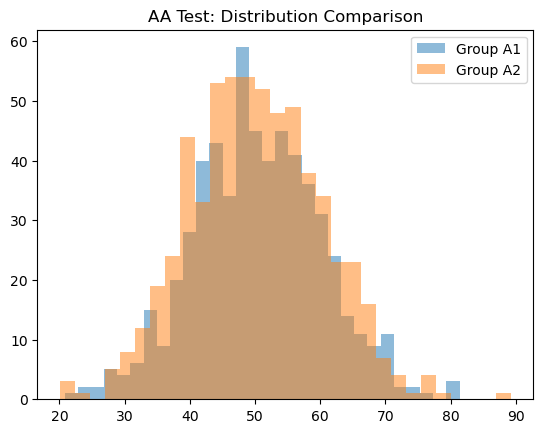

In [38]:
# Step 6: Run 2-sample (independent) t-test
t_stat, p_value = stats.ttest_ind(group_A1, group_A2)

print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("⚠️ Statistically significant difference found — check randomization.")
else:
    print("✅ No significant difference — randomization looks good.")

# Step 7: Visualize distributions
plt.hist(group_A1, bins=30, alpha=0.5, label='Group A1');
plt.hist(group_A2, bins=30, alpha=0.5, label='Group A2');
plt.title('AA Test: Distribution Comparison');
plt.legend();
plt.show();

[Back to the top](#Contents)
___


# Power Analysis

Power analysis helps determine the **minimum sample size** needed to detect an expected effect with statistical confidence.

`Why It Matters:`
- Avoids **underpowered** tests (can't detect real differences)
- Avoids **overpowered** tests (wastes resources)
- Balances tradeoffs between **sample size**, **effect size**, **confidence level**, and **statistical power**

`Key Inputs:`
- **alpha (α):** Significance level (probability of Type I error, usually 0.05)
- **Power (1 - β):** Probability of detecting a true effect (commonly 0.80 or 0.90)
- **Baseline conversion rate:** Current performance (e.g., 10%)
- **Minimum Detectable Effect (MDE):** Smallest lift you care to detect (e.g., +2%)

We use a two-sample z-test for proportions to estimate sample size per group.

In [49]:
import numpy as np
import scipy.stats as stats

def calculate_sample_size(alpha, power, baseline_rate, mde):
    """
    Calculate the sample size required for each group in an A/B test.
    
    Parameters:
    - alpha: Significance level (e.g., 0.05)
    - power: Desired power (e.g., 0.80)
    - baseline_rate: Baseline conversion rate (as a proportion, e.g., 0.10)
    - mde: Minimum Detectable Effect (as a proportion, e.g., 0.02 for +2%)

    Returns:
    - Sample size per group
    """
    # Z-scores
    z_alpha = stats.norm.ppf(1 - alpha / 2)
    z_beta = stats.norm.ppf(power)

    # Pooled standard error
    pooled_std = np.sqrt(
        2 * baseline_rate * (1 - baseline_rate) + 
        mde**2 / 2  # adjustment for effect size difference
    )

    # Sample size formula
    n = ((z_alpha + z_beta)**2 * 2 * baseline_rate * (1 - baseline_rate)) / (mde**2)
    return int(np.ceil(n))

# Example usage
alpha = 0.05
power = 0.80
baseline_rate = 0.10  # 10% baseline conversion
mde = 0.02            # 2% lift

required_sample_size = calculate_sample_size(alpha, power, baseline_rate, mde)

# Conclusions
print("📈 Power Analysis Summary")
print(f"- Baseline conversion rate: {baseline_rate}")
print(f"- Minimum detectable effect (MDE): {mde}")
print(f"- Target conversion rate: {(baseline_rate + mde):.2f}")
print(f"- Significance level (α): {alpha}")
print(f"- Statistical power (1 - β): {power}")

print(f"\n✅ Result:")
print(f"To detect a lift from {baseline_rate} to {(baseline_rate + mde):.2f} with")
print(f"{power*100:.0f}% power and {alpha*100:.0f}% significance level,")
print(f"you need at least {required_sample_size} users in each group (control and treatment).")
print(f"Total required sample size: {required_sample_size * 2} users.\n")

📈 Power Analysis Summary
- Baseline conversion rate: 0.1
- Minimum detectable effect (MDE): 0.02
- Target conversion rate: 0.12
- Significance level (α): 0.05
- Statistical power (1 - β): 0.8

✅ Result:
To detect a lift from 0.1 to 0.12 with
80% power and 5% significance level,
you need at least 3532 users in each group (control and treatment).
Total required sample size: 7064 users.



[Back to the top](#Contents)
___

# AB Testing
- Experiment Implementation

### 🛠️ Metric Tracked:
- **Primary metric:** Conversion rate (binary: clicked = 1, did not click = 0)
- **Unit of analysis:** Unique user

---

#### 📈 Outcome Analysis Plan:
- Two-sample **z-test for proportions** to compare conversion rates
- Compute confidence intervals and p-values
- Optional: visualizations of effect size and confidence bounds

In [51]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

np.random.seed(42)

# Step 1: Simulate eligible population
n = 7064  # from power analysis
users = pd.DataFrame({
    'user_id': np.arange(1, n + 1),
})

# Step 2: Randomly assign users to control or treatment
users['group'] = np.random.choice(['control', 'treatment'], size=n, replace=True)
users

,user_id,group
0,1,control
1,2,treatment
2,3,control
3,4,control
4,5,control
...,...,...
7059,7060,treatment
7060,7061,treatment
7061,7062,control
7062,7063,treatment


In [52]:
# Step 3: Simulate conversions
# Assume baseline = 0.10, treatment = 0.12
conversion_rate = {
    'control': 0.10,
    'treatment': 0.12
}
users['converted'] = users['group'].apply(lambda g: np.random.binomial(1, conversion_rate[g]))
users

,user_id,group,converted
0,1,control,0
1,2,treatment,0
2,3,control,0
3,4,control,0
4,5,control,0
...,...,...,...
7059,7060,treatment,0
7060,7061,treatment,0
7061,7062,control,0
7062,7063,treatment,0


In [70]:
# Step 4: View summary
summary = users.groupby('group')['converted'].agg(['count', 'sum', 'mean']).rename(columns={
    'count': 'n_users',
    'sum': 'n_converted',
    'mean': 'conversion_rate'
})
summary

,n_users,n_converted,conversion_rate
group,,,
control,3557,308,0.086590
treatment,3507,432,0.123182


In [71]:
# Step 5: Run 2-proportion z-test
control_conv = summary.loc['control', 'conversion_rate']
treatment_conv = summary.loc['treatment', 'conversion_rate']
n_control = summary.loc['control', 'n_users']
n_treatment = summary.loc['treatment', 'n_users']
x_control = summary.loc['control', 'n_converted']
x_treatment = summary.loc['treatment', 'n_converted']

# Pooled conversion rate
p_pooled = (x_control + x_treatment) / (n_control + n_treatment)
se_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_control + 1/n_treatment))

z_stat = (treatment_conv - control_conv) / se_pooled
p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

[Back to the top](#Contents)
___


# Results 
- Analyzing results and check for statistical significance.

#### Conversion Rates


📊 Z-Test Results
Z-statistic: 5.0213
P-value    : 0.0000
✅ Statistically significant difference detected.


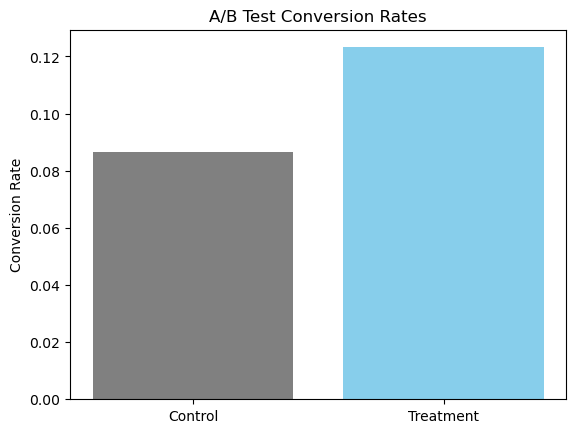

In [72]:
print(f"\n📊 Z-Test Results")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value    : {p_value:.4f}")
if p_value < 0.05:
    print("✅ Statistically significant difference detected.")
else:
    print("🚫 No significant difference detected.")

# Optional: Plot
plt.bar(['Control', 'Treatment'], [control_conv, treatment_conv], color=['gray', 'skyblue']);
plt.ylabel('Conversion Rate');
plt.title('A/B Test Conversion Rates');
plt.show();


In [69]:
# Already generated in earlier step, but good to reinforce
summary

,n_users,n_converted,conversion_rate
group,,,
control,3557,308,0.086590
treatment,3507,432,0.123182


#### Bar Chart of Conversion Rates

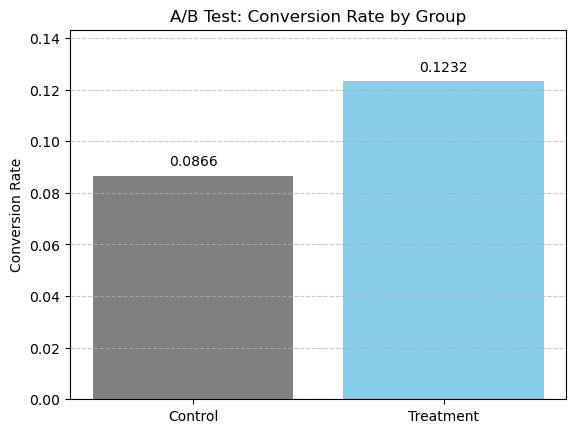

In [65]:
# Plot bar chart
fig, ax = plt.subplots()
bars = ax.bar(['Control', 'Treatment'],
              [control_conv, treatment_conv],
              color=['gray', 'skyblue'])

# Add values on top
for bar in bars:
    height = bar.get_height();
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # vertical offset
                textcoords="offset points",
                ha='center', va='bottom');
ax.set_ylabel('Conversion Rate');
ax.set_title('A/B Test: Conversion Rate by Group');
ax.set_ylim(0, max(control_conv, treatment_conv) + 0.02);
ax.grid(axis='y', linestyle='--', alpha=0.7);
plt.show();

#### 95% Confidence Intervals (`outcome of group`)

- The 95% confidence interval gives a range in which we expect the **true conversion rate** to fall for each group.
- If the confidence intervals **do not overlap**, it's strong evidence that the difference is statistically significant.
- If they **do overlap**, it doesn't guarantee insignificance — you still need the p-value to decide — but it suggests caution when interpreting lift.

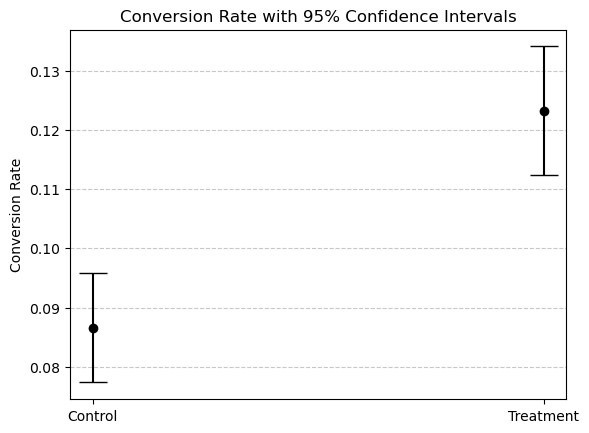

In [61]:
# Compute confidence intervals
def compute_ci(p, n, z=1.96):
    se = np.sqrt(p * (1 - p) / n)
    return (p - z*se, p + z*se)

ci_control = compute_ci(control_conv, n_control)
ci_treatment = compute_ci(treatment_conv, n_treatment)

# Plot with error bars
plt.errorbar(['Control', 'Treatment'],
             [control_conv, treatment_conv],
             yerr=[[control_conv - ci_control[0], treatment_conv - ci_treatment[0]],
                   [ci_control[1] - control_conv, ci_treatment[1] - treatment_conv]],
             fmt='o', capsize=10, color='black')
plt.ylabel('Conversion Rate');
plt.title('Conversion Rate with 95% Confidence Intervals');
plt.grid(axis='y', linestyle='--', alpha=0.7);
plt.show();

#### 95% Confidence Intervals (`difference in outcomes`). AKA `Lift Analysis`

In [73]:
# Calculate absolute lift
lift = treatment_conv - control_conv

# Standard error for the difference in proportions
se_diff = np.sqrt(
    (control_conv * (1 - control_conv) / n_control) +
    (treatment_conv * (1 - treatment_conv) / n_treatment)
)

# 95% Confidence Interval for the lift
z = 1.96  # for 95%
ci_lower = lift - z * se_diff
ci_upper = lift + z * se_diff

# Print result
print("📈 Lift Analysis")
print(f"- Absolute Lift: {lift:.4f}")
print(f"- 95% Confidence Interval for Lift: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Interpretation
if ci_lower > 0:
    print("✅ We're 95% confident the new version improved conversion.")
elif ci_upper < 0:
    print("🚫 We're 95% confident the new version hurt conversion.")
else:
    print("🤷 The confidence interval includes 0 — we can't say the lift is statistically significant.")


📈 Lift Analysis
- Absolute Lift: 0.0366
- 95% Confidence Interval for Lift: [0.0223, 0.0509]
✅ We're 95% confident the new version improved conversion.


#### Final Conclusion

In [78]:
print("" + "="*40)
print("          📊FINAL A/B TEST SUMMARY")
print("="*40)

print(f"👥  Control conversion rate   :  {control_conv:.4f}")
print(f"🧪  Treatment conversion rate :  {treatment_conv:.4f}")
print(f"📈  Absolute lift             :  {(treatment_conv - control_conv):.4f}")
print(f"📊  Percentage lift           :  {((treatment_conv - control_conv)/control_conv):.2%}")
print(f"🧪  P-value (from z-test)     :  {p_value:.4f}")

print("-" * 40)

if p_value < 0.05:
    print("✅  RESULT: Statistically significant improvement detected.")
else:
    print("❌  RESULT: No statistically significant difference detected.")

print("="*40 + "\n")


          📊FINAL A/B TEST SUMMARY
👥  Control conversion rate   :  0.0866
🧪  Treatment conversion rate :  0.1232
📈  Absolute lift             :  0.0366
📊  Percentage lift           :  42.26%
🧪  P-value (from z-test)     :  0.0000
----------------------------------------
✅  RESULT: Statistically significant improvement detected.



[Back to the top](#Contents)
___


# How Long
##### to run the test?


The runtime of an A/B test depends on how quickly you can reach the required **sample size per group**, as estimated during power analysis.

##### Key Inputs:
- ✅ Daily eligible traffic volume
- ✅ Required sample size (from power analysis)
- ✅ Whether traffic is split 50/50 or unevenly

##### Formula:
> **Days = Required Sample Size per Group / (Daily Eligible Users × Group Split Proportion)**

This ensures the experiment runs **long enough to detect the effect** with the desired statistical confidence.

##### ⏳ How Long to Run an A/B Test — Real-World Guide

1. **Estimate sample size** needed (done via power analysis)
2. **Understand your traffic** — how many eligible users per day?
3. **Factor in group split** — if it's 50/50, each group gets half the traffic
4. **Divide required sample per group by daily users per group** to estimate days

---

##### 💡 Real-World Recommendations

- ✅ **Ramp-Up Period**: Don’t go full traffic on Day 1. Start with 5%, then 25%, then 50% over 2–3 days. This is safer and helps catch bugs early.
  
- ✅ **Cool-Down Buffer**: Let the test stabilize before analysis. Avoid cutting off during weekends or anomalies.
  
- ✅ **Trust Checks**:
  - Run an **A/A test first** to validate setup
  - Do an **SRM check** to confirm assignment balance
  - Monitor **guardrail metrics** (e.g., bounce rate, latency)

- ⏳ Add **1–2 buffer days** for these. It’s not just about stats — it’s about reliability and business trust.

---

##### 🧠 Tip
> “We typically recommend calculating sample size from power analysis, then dividing by daily traffic per variant. But we also factor in buffer days for ramp-up, trust checks, and traffic noise — just to make sure we don’t rush analysis before data is stable.”

> “We use power analysis to plan — it gives stakeholders a timeline and sets expectations.
But we don’t blindly stop based on sample size. I monitor SRM, metric stability, cohort coverage, and confidence intervals before making the call. We want decisions that are trustworthy, not just statistically complete.”

In [81]:
def estimate_total_test_duration(required_sample_size_per_group, daily_eligible_users, allocation_ratio=0.5):
    """
    Estimate total days needed to complete an A/B test for both groups.

    Parameters:
    - required_sample_size_per_group: int, sample size needed per group (from power analysis)
    - daily_eligible_users: int, total eligible users arriving each day
    - allocation_ratio: float, proportion of traffic sent to each group (e.g., 0.5 for 50/50)

    Returns:
    - Estimated total number of days to complete both groups
    """
    # Max group load per day (assuming symmetric or asymmetric allocation)
    daily_users_per_group = daily_eligible_users * allocation_ratio
    days_needed = required_sample_size_per_group / daily_users_per_group

    return int(np.ceil(days_needed))

# Example Usage
required_sample = 3532
daily_users = 10000
allocation = 0.5  # 50% of users per group

total_days = estimate_total_test_duration(required_sample, daily_users, allocation)
buffer_days = 2  # For ramp-up, cool-down, or traffic anomalies

print(f"📅 Estimated minimum duration per group : {total_days} days")
print(f"📦 Add buffer (ramp-up, weekends, trust checks): {buffer_days} days")
print(f"🧮 Total recommended runtime             : {total_days + buffer_days} days\n")


📅 Estimated minimum duration per group : 1 days
📦 Add buffer (ramp-up, weekends, trust checks): 2 days
🧮 Total recommended runtime             : 3 days



#### Monitoring Dashboard
- Guardrails
-

[Back to the top](#Contents)
___


# Post Hoc Analysis
- Post Hoc Analysis: Additional Tests after primary analysis to explore further patterns

## 🔍 Post-Hoc Analysis

Post-hoc analysis helps interpret test results **beyond the primary metric**, and answer key follow-up questions like:

- Did the effect differ by segment (e.g. platform, user type)?
- Were any guardrail metrics negatively impacted?
- What does the lift mean in terms of actual revenue or conversions?
- What happens if we roll this out 100%?

This step helps turn **statistical significance into business confidence.**


[Back to the top](#Contents)
___


# Other Notes

### Experimentation Infrastructure

[Back to the top](#Contents)
___


# Scratch Notes


In [ ]:
# Simulate data
n_control = 5000  # Sample size for control group
n_treatment = 5000  # Sample size for treatment group

# Assume conversion rate is 10% for control and 12% for treatment
control_conversions = np.random.binomial(1, 0.10, n_control)
treatment_conversions = np.random.binomial(1, 0.12, n_treatment)

# Create DataFrame
df = pd.DataFrame({
    'group': ['control'] * n_control + ['treatment'] * n_treatment,
    'conversion': np.concatenate([control_conversions, treatment_conversions])
})
df.head()
df.shape

# Display summary
df.groupby('group')['conversion'].agg(['mean', 'count', 'sum'])


#### AB Testing

1. Chi-Square Test (Categorical Data - Conversion Rates)     
Used when testing differences in proportions (e.g., conversion rate increase).

In [ ]:
from scipy.stats import chi2_contingency

# Create contingency table
conversion_table = pd.crosstab(df['group'], df['conversion'])

# Chi-Square Test
chi2_stat, p_value, dof, expected = chi2_contingency(conversion_table)

# Print results
print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Check significance
alpha = 0.05  # 95% confidence level
if p_value < alpha:
    print("Reject the null hypothesis: Significant difference detected.")
else:
    print("Fail to reject the null hypothesis: No significant difference detected.")


2. Independent T-Test (Continuous Data - Avg. Time Spent, Revenue)    
Used when comparing means of continuous data between two independent groups.

In [ ]:
from scipy.stats import ttest_ind

# Perform independent t-test
t_stat, p_val = ttest_ind(control_conversions, treatment_conversions)

print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_val:.4f}")

if p_val < alpha:
    print("Reject the null hypothesis: The new feature has a significant effect.")
else:
    print("Fail to reject the null hypothesis: No significant difference detected.")


3. Paired T-Test (Before/After Tests - Same Users)    
Used when measuring differences within the same group (e.g., before vs. after).

In [ ]:
from scipy.stats import ttest_rel

# Example: User engagement before & after a UI change
before = np.random.normal(200, 25, 100)  # Mean 200 sec, std dev 25
after = np.random.normal(210, 25, 100)  # Mean 210 sec, std dev 25

t_stat, p_val = ttest_rel(before, after)

print(f"Paired T-Test Statistic: {t_stat:.4f}")
print(f"P-Value: {p_val:.4f}")

if p_val < 0.05:
    print("Significant difference detected.")
else:
    print("No significant difference detected.")


4. Mann-Whitney U Test (Non-Normal Continuous Data)
A non-parametric test used when data isn’t normally distributed (e.g., skewed revenue).

In [ ]:
from scipy.stats import mannwhitneyu

# Example: Revenue data (skewed distribution)
control_revenue = np.random.exponential(50, 5000)  # Skewed
treatment_revenue = np.random.exponential(55, 5000)  # Skewed

u_stat, p_val = mannwhitneyu(control_revenue, treatment_revenue)

print(f"Mann-Whitney U Statistic: {u_stat:.4f}")
print(f"P-Value: {p_val:.4f}")

if p_val < 0.05:
    print("Significant difference detected.")
else:
    print("No significant difference detected.")


 5. Bayesian A/B Testing (Alternative Approach)    
Instead of p-values, Bayesian A/B testing provides posterior probability distributions.

In [ ]:
# import pymc3 as pm

# # Simulated conversion data
# control_conversions = np.sum(np.random.binomial(1, 0.10, 5000))
# treatment_conversions = np.sum(np.random.binomial(1, 0.12, 5000))

# with pm.Model():
#     control_rate = pm.Beta("control_rate", alpha=1, beta=1)
#     treatment_rate = pm.Beta("treatment_rate", alpha=1, beta=1)

#     # Priors
#     control = pm.Binomial("control", n=5000, p=control_rate, observed=control_conversions)
#     treatment = pm.Binomial("treatment", n=5000, p=treatment_rate, observed=treatment_conversions)

#     trace = pm.sample(2000, return_inferencedata=True)

# # Compute probability that the treatment is better
# prob_treatment_better = (trace.posterior["treatment_rate"] > trace.posterior["control_rate"]).mean().item()

# print(f"Probability that the treatment is better: {prob_treatment_better:.4f}")


6. Power Analysis (How Much Data Do You Need?)
Used to determine sample size before running an experiment.

In [ ]:
from statsmodels.stats.power import TTestIndPower

# Define parameters
effect_size = 0.02  # Expected lift in conversion rate
alpha = 0.05  # Significance level
power = 0.8  # Desired statistical power

# Compute sample size per group
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, alpha=alpha, ratio=1)

print(f"Required Sample Size per Group: {int(sample_size)}")

[Back to the top](#Contents)
___